In [ ]:
!pip install opencv-python
!pip install pandas
!pip install matplotlib
!pip install gdown
!pip install sklearn
!pip install scipy
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import gdown as gdown
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
from torchvision.transforms.transforms import Normalize

In [2]:
url =  'https://drive.google.com/uc?export=download&id=1UGNAWPEe2YtkZNx3chPJRNbJMyHXU3Z6'
output = 'A_Z Handwritten Data.csv'
gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?export=download&id=1UGNAWPEe2YtkZNx3chPJRNbJMyHXU3Z6
To: C:\Users\Jorge\AI\A_Z Handwritten Data.csv
100%|██████████| 699M/699M [00:50<00:00, 13.7MB/s] 


'A_Z Handwritten Data.csv'

In [110]:
PATH = os.getcwd()
data = pd.read_csv(PATH + "/A_Z Handwritten Data.csv", header=None).astype('float32').to_numpy()
# column 0 = label
print(data.shape)

(372451, 785)


In [111]:
np.random.shuffle(data)
x_data = data[:, 1:]
labels = data[:, 0]
y_data = []
for i in labels:
  labels_v = np.zeros(26, dtype=np.float32)
  labels_v[int(i)] = 1
  y_data.append(labels_v)
y_data = np.array(y_data)
normalizer = MinMaxScaler()
normalizer.fit(x_data)
print(x_data.shape)
print(y_data.shape)

(372451, 784)
(372451, 26)


17 14 18 2 12 9 19 18 20 18 

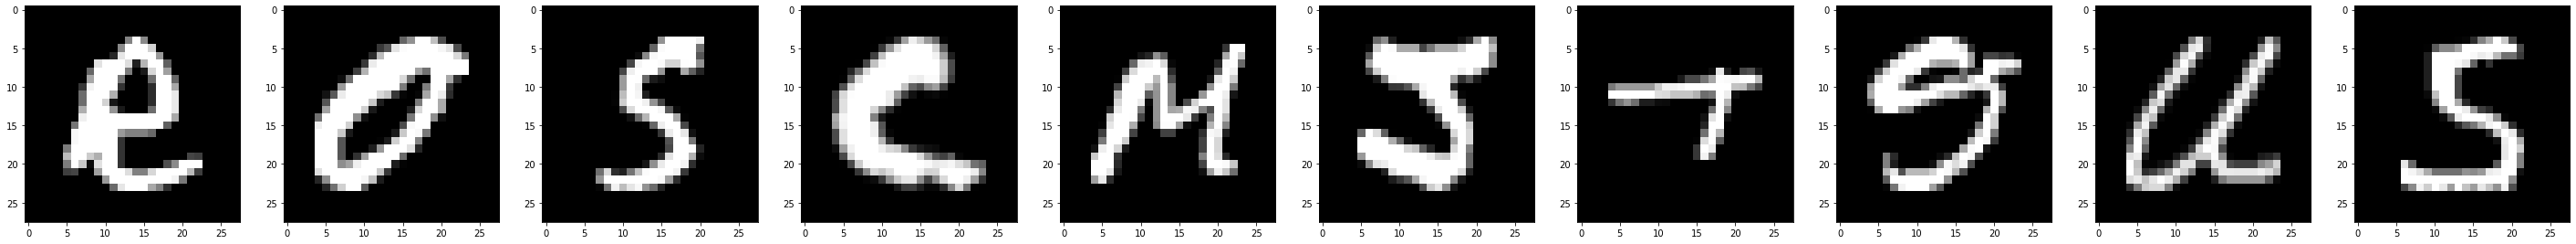

In [112]:
plt.figure(figsize = (50, 10))
r, c = 1, 10
for i in range(r * c):  
    plt.subplot(r, c, i+1)
    plt.imshow(x_data[i].reshape(28,28), cmap='gray')
    print(np.argmax(y_data[i]), end = " ")
plt.show()

In [113]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [114]:
transformToTensor = transforms.ToTensor()
data_set = []
for i in range(x_data.shape[0]):
    data_set.append(( transformToTensor(x_data[i].reshape(28, 28)), torch.tensor(y_data[i]) ))

In [115]:
n_train = int(0.8 * len(x_data))
n_validation = int(0.1 * len(x_data))
train_set = data_set[:n_train]
validation_set = data_set[n_train:n_train + n_validation]
test_set = data_set[n_train + n_validation:]

print("train set length:", len(train_set))
print("validation set length:", len(validation_set))
print("test set length:", len(test_set))
print("set type:", type(train_set))
print("data set type:", type(train_set[0]))
a, b = train_set[0] 
print("first data set type:", type(a))
print("first data shape:", a.shape)
print("second data set type:", type(b))
print("second data shape:", b.shape)

train set length: 297960
validation set length: 37245
test set length: 37246
set type: <class 'list'>
data set type: <class 'tuple'>
first data set type: <class 'torch.Tensor'>
first data shape: torch.Size([1, 28, 28])
second data set type: <class 'torch.Tensor'>
second data shape: torch.Size([26])


In [116]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

In [118]:
def train(model, train_loader, Epochs, loss_fn):
    train_loss_avg = []
    validation_loss_avg = []
    
    for epoch in range(Epochs):
        model.train()

        train_loss_avg.append(0)
        num_batches = 0
        total = 0
        correct = 0

        for image_batch, label_batch in train_loader:
            image_batch = image_batch.to(device)
            label_batch = label_batch.to(device)
            
            label_batch_pred = model(image_batch)
            loss = loss_fn(label_batch_pred, label_batch)

            _, test = torch.max(label_batch.data, 1)
            _, predicted = torch.max(label_batch_pred.data, 1)
            total += label_batch.size(0)
            correct += (predicted == test).sum().item()
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss_avg[-1] += loss.item()
            num_batches += 1

        train_loss_avg[-1] /= num_batches
        train_accuracy = 100.0 * correct / total 

        validation_loss_avg.append(0)
        num_batches = 0
        total = 0
        correct = 0

        model.eval()

        with torch.no_grad():
            for image_batch, label_batch in validation_loader:
                image_batch = image_batch.to(device)
                label_batch = label_batch.to(device)
            
                label_batch_pred = model(image_batch)
                loss = loss_fn(label_batch_pred, label_batch)

                _, test = torch.max(label_batch.data, 1)
                _, predicted = torch.max(label_batch_pred.data, 1)
                total += label_batch.size(0)
                correct += (predicted == test).sum().item()

                validation_loss_avg[-1] += loss.item()
                num_batches += 1

        validation_loss_avg[-1] /= num_batches
        validation_accuracy = 100.0 * correct / total

        print(f'Epoch [{epoch+1} / {Epochs}] training error: {train_loss_avg[-1]:.4f}, training accuracy: {train_accuracy:.4f}%, validation error: {validation_loss_avg[-1]:.4f}, validation accuracy: {validation_accuracy:.4f}%')
      
    return train_loss_avg, validation_loss_avg

In [126]:
class Lenet5(nn.Module):
    def __init__(self):
        super(Lenet5, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(0, 0)),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.AdaptiveAvgPool2d(output_size=(5, 5))
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.1, inplace = False),
            nn.Linear(in_features=400, out_features=100, bias=True),
            nn.ReLU(inplace = True),
            nn.Dropout(p=0.1, inplace = False),
            nn.Linear(in_features=100, out_features=26, bias=True),
         )
        
    def forward(self, image):
        out = self.features(image)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

In [128]:
model = Lenet5()
model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001, weight_decay=1e-5)

training_loss, validation_loss = train(model,train_loader,20,loss)

Epoch [1 / 20] training error: 0.2314, training accuracy: 93.5787%, validation error: 0.0892, validation accuracy: 97.3473%
Epoch [2 / 20] training error: 0.1116, training accuracy: 96.7751%, validation error: 0.0708, validation accuracy: 97.9487%
Epoch [3 / 20] training error: 0.0965, training accuracy: 97.2308%, validation error: 0.0667, validation accuracy: 98.1018%
Epoch [4 / 20] training error: 0.0882, training accuracy: 97.4312%, validation error: 0.0644, validation accuracy: 98.2360%
Epoch [5 / 20] training error: 0.0837, training accuracy: 97.5983%, validation error: 0.0606, validation accuracy: 98.2441%
Epoch [6 / 20] training error: 0.0805, training accuracy: 97.6903%, validation error: 0.0707, validation accuracy: 98.0024%
Epoch [7 / 20] training error: 0.0780, training accuracy: 97.7551%, validation error: 0.0557, validation accuracy: 98.4481%
Epoch [8 / 20] training error: 0.0756, training accuracy: 97.8232%, validation error: 0.0590, validation accuracy: 98.2763%
Epoch [9

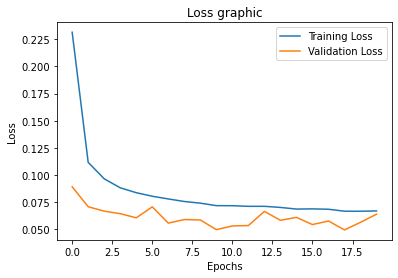

In [133]:
fig = plt.figure()
plt.plot(training_loss, label = 'Training Loss')
plt.plot(validation_loss, label = 'Validation Loss')
plt.title("Loss graphic")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [135]:
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for image_batch, label_batch in test_loader:
        image_batch = image_batch.to(device)
    
        label_batch_pred = model(image_batch)

        image_batch = image_batch.to('cpu')
        label_batch_pred = label_batch_pred.to('cpu')

        _, test = torch.max(label_batch.data, 1)
        _, predicted = torch.max(label_batch_pred.data, 1)
        total += label_batch.size(0)
        correct += (predicted == test).sum().item()
print(f'Total tested: {total}')
print(f'Correct tested: {correct}')
print(f'Accuracy: {(100.0 * correct / total):.4f} %')

Total tested: 37246
Correct tested: 36615
Accuracy: 98.3059 %


In [136]:
torch.save(model, PATH + '/Lenet5.pt')

In [147]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace = True),
            nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False),
            nn.AdaptiveAvgPool2d(output_size=(6, 6))
        )
        self.classifier = nn.Sequential(
            #nn.Dropout(p=0.1, inplace = False),
            nn.Linear(in_features=9216, out_features=2048, bias=True),
            nn.ReLU(inplace = True),
            #nn.Dropout(p=0.1, inplace = False),
            nn.Linear(in_features=2048, out_features=512, bias=True),
            nn.ReLU(inplace = True),
            nn.Linear(in_features=512, out_features=26, bias=True)
         )

    def forward(self, image):
        out = self.features(image)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

In [148]:
model = AlexNet()
model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001, weight_decay=1e-5)

training_loss, validation_loss = train(model,train_loader,20,loss)

Epoch [1 / 20] training error: 0.2724, training accuracy: 93.4531%, validation error: 0.1445, validation accuracy: 96.6089%
Epoch [2 / 20] training error: 0.1221, training accuracy: 97.2067%, validation error: 0.1058, validation accuracy: 97.5916%
Epoch [3 / 20] training error: 0.1026, training accuracy: 97.6668%, validation error: 0.1007, validation accuracy: 97.6802%
Epoch [4 / 20] training error: 0.0955, training accuracy: 97.8789%, validation error: 0.0972, validation accuracy: 97.7984%
Epoch [5 / 20] training error: 0.0868, training accuracy: 98.0615%, validation error: 0.0920, validation accuracy: 97.8923%
Epoch [6 / 20] training error: 0.0847, training accuracy: 98.1407%, validation error: 0.0932, validation accuracy: 98.0132%
Epoch [7 / 20] training error: 0.0890, training accuracy: 98.1199%, validation error: 0.1083, validation accuracy: 97.6990%
Epoch [8 / 20] training error: 0.0812, training accuracy: 98.2927%, validation error: 0.1131, validation accuracy: 97.8494%
Epoch [9

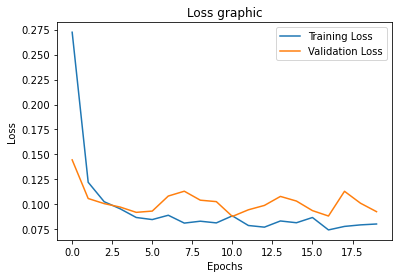

In [152]:
fig = plt.figure()
plt.plot(training_loss, label = 'Training Loss')
plt.plot(validation_loss, label = 'Validation Loss')
plt.title("Loss graphic")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [153]:
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for image_batch, label_batch in test_loader:
        image_batch = image_batch.to(device)
    
        label_batch_pred = model(image_batch)

        image_batch = image_batch.to('cpu')
        label_batch_pred = label_batch_pred.to('cpu')

        _, test = torch.max(label_batch.data, 1)
        _, predicted = torch.max(label_batch_pred.data, 1)
        total += label_batch.size(0)
        correct += (predicted == test).sum().item()
print(f'Total tested: {total}')
print(f'Correct tested: {correct}')
print(f'Accuracy: {(100.0 * correct / total):.4f} %')

Total tested: 37246
Correct tested: 36486
Accuracy: 97.9595 %


In [154]:
torch.save(model, PATH + '/Alexnet.pt')

In [155]:
model = torch.load(PATH + '/Lenet5.pt')
model = model.to(device)

model.eval()

correct = 0
total = 0
with torch.no_grad():
    for image_batch, label_batch in test_loader:
        image_batch = image_batch.to(device)
    
        label_batch_pred = model(image_batch)

        image_batch = image_batch.to('cpu')
        label_batch_pred = label_batch_pred.to('cpu')

        _, test = torch.max(label_batch.data, 1)
        _, predicted = torch.max(label_batch_pred.data, 1)
        total += label_batch.size(0)
        correct += (predicted == test).sum().item()
print(f'Total tested: {total}')
print(f'Correct tested: {correct}')
print(f'Accuracy: {(100.0 * correct / total):.4f} %')


Total tested: 37246
Correct tested: 36615
Accuracy: 98.3059 %


In [156]:
model = torch.load(PATH + '/Alexnet.pt')
model = model.to(device)

model.eval()

correct = 0
total = 0
with torch.no_grad():
    for image_batch, label_batch in test_loader:
        image_batch = image_batch.to(device)
    
        label_batch_pred = model(image_batch)

        image_batch = image_batch.to('cpu')
        label_batch_pred = label_batch_pred.to('cpu')

        _, test = torch.max(label_batch.data, 1)
        _, predicted = torch.max(label_batch_pred.data, 1)
        total += label_batch.size(0)
        correct += (predicted == test).sum().item()
print(f'Total tested: {total}')
print(f'Correct tested: {correct}')
print(f'Accuracy: {(100.0 * correct / total):.4f} %')


Total tested: 37246
Correct tested: 36486
Accuracy: 97.9595 %
